In [1]:
import numpy as np
from qiskit import QuantumRegister, QuantumCircuit, transpile
from qiskit.quantum_info.operators import Operator
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from staggered_dsg_circuit_3t_bin import *

In [2]:
size_degree = 2
shots = 4000

displacement_dict = {"0000":0, "0001":1, "0010":1, 
                     "0011":9, "0100":7, "0101":4,
                     "0110":9, "0111":4, "1000":7}

In [3]:
steps = 300
dt = 0.01
layers = 1
t = np.linspace(dt, steps*dt, steps)
name = f'dsg_log3tqw_tb_{steps*dt:.1f}s_{layers:d}ly'

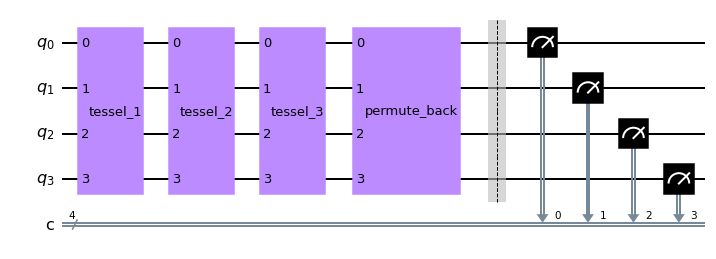

In [6]:
saveas = '\State_mapping_circuit'
staggered_dsg_circuit_3t_bin(size_degree, .5, layers, wrap=True, model='XY').draw('mpl', filename=f'Downloads{saveas}.jpg')

In [9]:
from qiskit.circuit import Parameter

t = Parameter('t')

In [14]:
# Build a subcircuit for ZZ(t) from single- and two-qubit gates

ZZ_qr = QuantumRegister(2)
ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')

ZZ_qc.cnot(0,1)
ZZ_qc.rz(2 * t, 1)
ZZ_qc.cnot(0,1)

# Convert custom quantum circuit into a gate
ZZ = ZZ_qc.to_instruction()

In [15]:

XX_qr = QuantumRegister(2)
XX_qc = QuantumCircuit(XX_qr, name='XX')

###EDIT CODE BELOW (add Clifford operator)

XX_qc.h([0, 1])

###DO NOT EDIT BELOW

XX_qc.append(ZZ, [0,1])

###EDIT CODE BELOW (add Clifford operator)

XX_qc.h([0, 1])

###DO NOT EDIT BELOW

# Convert custom quantum circuit into a gate
XX = XX_qc.to_instruction()

In [16]:

YY_qr = QuantumRegister(2)
YY_qc = QuantumCircuit(YY_qr, name='YY')

###EDIT CODE BELOW (add Clifford operator)

YY_qc.sdg([0,1])
YY_qc.h([0,1])

###DO NOT EDIT BELOW

YY_qc.append(ZZ, [0,1])

###EDIT CODE BELOW (add Clifford operator)

YY_qc.h([0,1])
YY_qc.s([0,1])

###DO NOT EDIT BELOW

# Convert custom quantum circuit into a gate
YY = YY_qc.to_instruction()

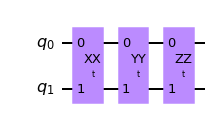

In [27]:
qc = QuantumCircuit(2)
qc.append(XX, [0,1])
qc.append(YY, [0,1])
qc.append(ZZ, [0,1])

filename = 'Qubit_mapping_Heisenberg.jpg'
qc.draw('mpl', filename=filename)

In [19]:
from qiskit.circuit.library.standard_gates import RXGate
from qiskit.extensions.unitary import UnitaryGate
from qiskit.quantum_info.operators import Operator

size = np.ceil(np.log2(3**size_degree)).astype(int)
theta = np.pi*.5/layers
zeta = np.exp(-2*1j*theta)
# interaction = RXGate(2*np.pi*t)
interaction = UnitaryGate(
    Operator([
    [(zeta+1)/2, (-1*zeta+1)/2],
    [(-1*zeta+1)/2, (zeta+1)/2]]),
    label='U'
)
interaction = interaction.control()

def tessellation1(size, interaction):
    """Staggered Quantum Walks tessellation 1"""
    tessel1 = QuantumCircuit(size)

    tessel1.mct([0,1], 2)    # flip 0011 <-> 0111 (with R.C.)

    tessel1.mct([0,1,2], 3)    # shift +1 (with C.I.)
    tessel1.mct([0,1], 2)
    tessel1.cx(0, 1)

    tessel1.cx(3, 0)    # flip 1000 <-> 1001

    tessel1.cx(0, 1)    # shift -1 (with C.I.)
    tessel1.mct([0,1], 2)
    tessel1.mct([0,1,2], 3)
    
    tessel1.barrier()
    
    tessel1.x(3)    # apply the interaction
    tessel1.append(interaction, [3,0])
    tessel1.x(3)

    tessel1.name = 'tessel_1'

    return tessel1

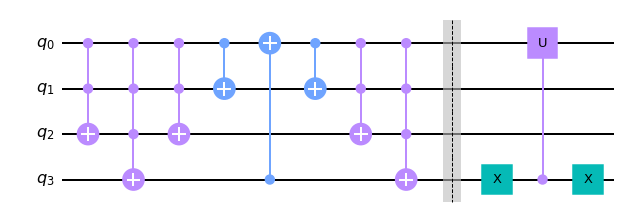

In [21]:
filename = 'State_mapping_Heisenberg.jpg'
tessellation1(size, interaction).draw('mpl', filename=filename)